<font size="+3"><strong>Predicting Damage with Decision Trees</strong></font>

In [4]:
import sqlite3 as sql
import matplotlib.pyplot as plt
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted

# Prepare Data

In [5]:
def wrangle(db_path):
    # Connect to database
    conn = sql.connect(db_path)

    # Construct query
    query = """
            SELECT s.* ,d.damage_grade
            FROM building_structure as s 
            JOIN building_damage AS d
            ON s.building_id = d.building_id
            WHERE s.district_id=36
            """

    # Read query results into DataFrame
    df = pd.read_sql(query,conn,"building_id")
    
    # identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    # create binary target
    df["damage_grade"]= df["damage_grade"].str[-1].astype(int)
    df["severe_damage"]=(df["damage_grade"]>3).astype(int)
    
    # Drop unnecessary features 
    drop_cols.append("technical_solution_proposed")
    
    # drop old target
    drop_cols.append("damage_grade")
    
    # drop multicollinearty columns
    drop_cols.append("count_floors_pre_eq")
    
    # drop haigh cardinality
    drop_cols.extend(["district_id","vdcmun_id","ward_id"])
    
    # drop leaky columns 
    df.drop(columns=drop_cols , inplace=True)
    
    return df

**Task 4.3.1:** Use the `wrangle` function above to import your data set into the DataFrame `df`. The path to the SQLite database is `"data/nepal.db"`


In [7]:
df = wrangle("data/nepal.db")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,...,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,severe_damage
building_id,,,,,,,,,,,,,,,,,,,,,
360101000011,40,336,6,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,...,0,0,0,0,0,0,0,0,0,1
360101000021,12,420,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,...,0,0,0,0,0,0,0,0,0,0
360101000031,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,...,0,0,0,0,0,0,0,0,0,0
360101000041,15,390,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,...,0,0,0,0,0,0,0,0,0,1
360101000051,15,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Square,...,0,0,0,0,0,0,0,0,0,1


## Split

**Task 4.3.2:** Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 


In [8]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]

**Task 4.3.3:** Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility. 


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2 , random_state=42
)

**Task 4.3.4:** Divide your training data (`X_train` and `y_train`) into training and validation sets using a randomized train-test split. Your validation data should be 20% of the remaining data. Don't forget to set a `random_state`.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train , y_train , test_size=0.2 , random_state=42
)

# Build Model

## Baseline

**Task 4.3.5:** Calculate the baseline accuracy score for your model.


In [11]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


## Iterate

**Task 4.3.6:** Create a pipeline named `model` that contains a `OrdinalEncoder` transformer and a `DecisionTreeClassifier` predictor. (Be sure to set a `random_state` for your predictor.) Then fit your model to the training data. 

In [29]:
# Build Model
model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=5,random_state=42)
)
# Fit model to training data
model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'data_type': dtype('O'...
                                          'mapping': Not attached       1
Attached-1 side    2
Attached-2 side    3
Attached-3 side    4
NaN               -2
dtype: int64},
                                         {'col': 'plan_configuration',
         

**Task 4.3.7:** Calculate the training and validation accuracy scores for your models. 


In [30]:
acc_train = accuracy_score(y_train,model.predict(X_train))
acc_val = model.score(X_val,y_val)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.71
Validation Accuracy: 0.71


**Task 4.3.8:** Use the [`get_depth`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.get_depth) method on the `DecisionTreeClassifier` in your model to see how deep your tree grew during training.

In [17]:
tree_depth = model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 52


**Task 4.3.9:** Create a range of possible values for `max_depth` hyperparameter of your model's `DecisionTreeClassifier`. `depth_hyperparams` should range from `1` to `50` by steps of `2`.


In [19]:
depth_hyperparams = range(1,52,2)

**Task 4.3.10:** Complete the code below so that it trains a model for every `max_depth` in `depth_hyperparams`. Every time a new model is trained, the code should also calculate the training and validation accuracy scores and append them to the `training_acc` and `validation_acc` lists, respectively. 
​

In [21]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val,y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.6878539836291953, 0.7064662677367062, 0.7141113134668882]
Validation Accuracy Scores: [0.6869996797950688, 0.7050112071725905, 0.7111751520973423]


**Task 4.3.11:** Create a visualization with two lines. The first line should plot the `training_acc` values as a function of `depth_hyperparams`, and the second should plot `validation_acc` as a function of `depth_hyperparams`. You x-axis should be labeled `"Max Depth"`, and the y-axis `"Accuracy Score"`. Also include a legend so that your audience can distinguish between the two lines. 


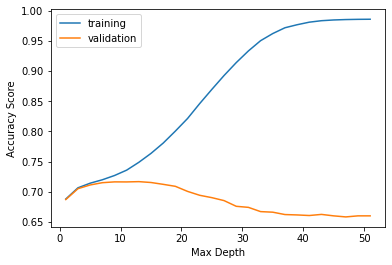

In [22]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams,training_acc,label="training")
plt.plot(depth_hyperparams,validation_acc,label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

## Evaluate

**Task 4.3.12:** Based on your visualization, choose the `max_depth` value that leads to the best validation accuracy score. Then retrain your original model with that `max_depth` value. Lastly, check how your tuned model performs on your test set by calculating the test accuracy score below. Were you able to resolve the overfitting problem with this new `max_depth`?


In [31]:
test_acc = model.score(X_test,y_test)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 0.72


# Communicate

**Task 4.3.13:** Complete the code below to use the [`plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) function from scikit-learn to visualize the decision logic of your model. 

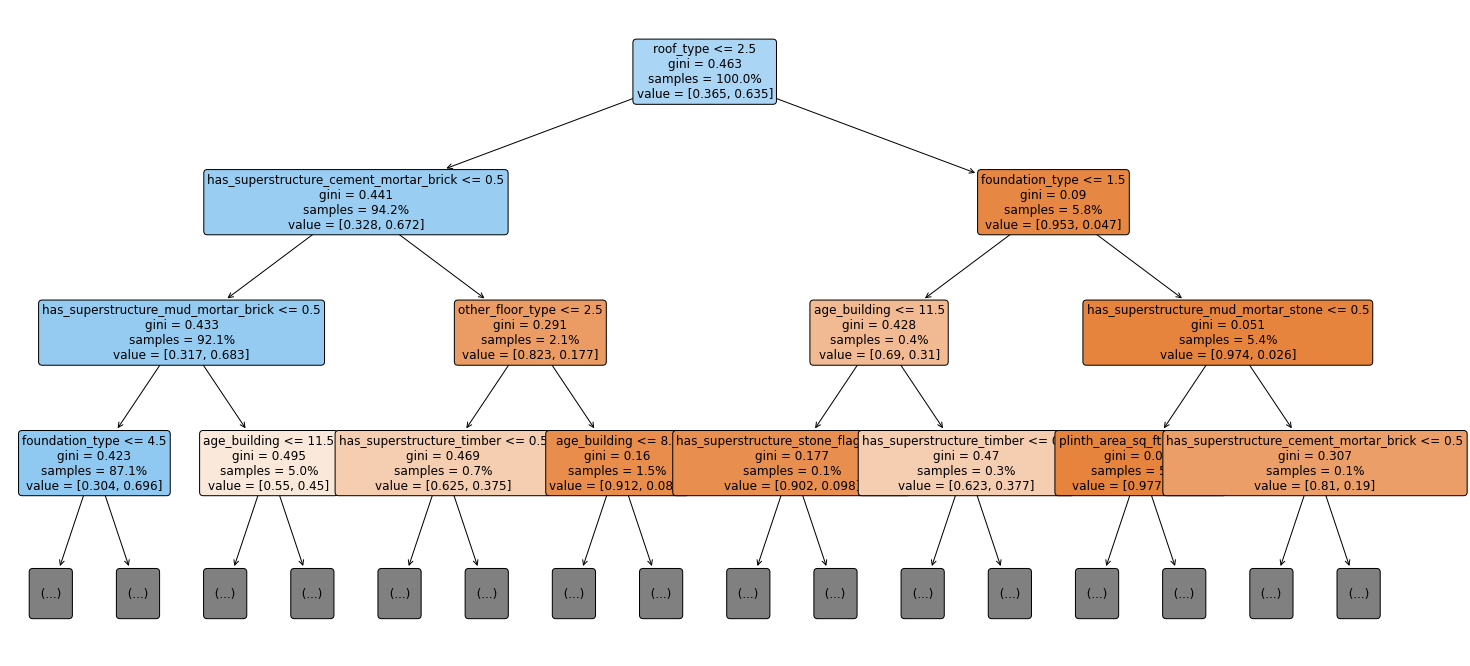

In [32]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model.named_steps["decisiontreeclassifier"],
    feature_names=X_train.columns,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

**Task 4.3.14:** Assign the feature names and importances of your model to the variables below. For the `features`, you can get them from the column names in your training set. For the `importances`, you access the [`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) attribute of your model's `DecisionTreeClassifier`. 


In [33]:
features = X_train.columns
importances = model.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
Importances: [0.02366697 0.00081847 0.0218738 ]


**Task 4.3.15:** Create a pandas Series named `feat_imp`, where the index is `features` and the values are your `importances`. The Series should be sorted from smallest to largest importance.


In [36]:
feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp.head()

has_superstructure_adobe_mud              0.0
has_superstructure_cement_mortar_stone    0.0
has_superstructure_rc_engineered          0.0
position                                  0.0
has_superstructure_other                  0.0
dtype: float64

**Task 4.3.16:** Create a horizontal bar chart with all the features in `feat_imp`. Be sure to label your x-axis `"Gini Importance"`.

Text(0, 0.5, 'feature')

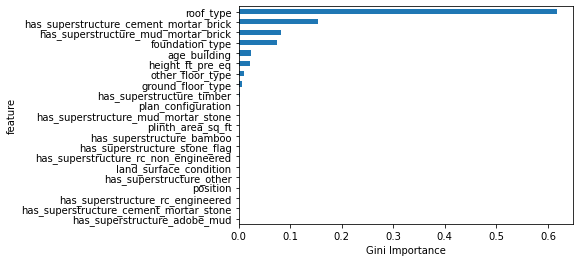

In [37]:
# Create horizontal bar chart
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("feature")